# Module 3: Bilevel Problems


## <span style="color:darkblue">*From competitive markets equilibrium to stackelberg games*</span>

We consider a simplified diesel market between 3 refineries. Each firm optimizes its own profit, subject only to a production capacity constraint. The firms have different efficiencies, represented by different marginal costs of production. Each player is maximizing their profit (minimising costs minus revenues):

\begin{align}
    \min_{x_i} \ & c_i x_i - p(x) x_i \\
    \text{s.t. } & x_i - X^{max}_i && \leq 0 \quad :\mu_i^{max} \\
    & - x_i && \leq 0 \\
\end{align}

where $p(x)$ is the market price.

In this exercise we investigate <span style="color:orange">**market-price formation**</span> and the <span style="color:orange">**production allocation**</span> in different market setups:

1)  Perfect competition  & Welfare maximization

2)  Cournot competition 

3)  Generalized Nash equilibrium 

4)  Stackelberg game  



#### Import code packages

In [44]:
# Import packages
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd
from pprint import pprint
from IPython.display import display, HTML
from pyomo.mpec import Complementarity, complements
import numpy as np
import os
from sys import platform


# Set up the PATH solver
# Set the PATH license string (from https://pages.cs.wisc.edu/~ferris/path.html)
os.environ['PATH_LICENSE_STRING'] = "2830898829&Courtesy&&&USR&45321&5_1_2021&1000&PATH&GEN&31_12_2025&0_0_0&6000&0_0"

# Set path to PATH executable (dependent on your OS)
if platform == "linux" or platform == "linux2":  # linux
    path_executable = os.path.join(os.getcwd(), 'path', 'linux', 'pathampl')
elif platform == "darwin":  # Mac OS X
    path_executable = os.path.join(os.getcwd(), 'path', 'macos', 'pathampl')
else:  # platform == "win32": # Windows
    path_executable = os.path.join(os.getcwd(), 'path', 'windows', 'pathampl.exe')


#### Problem data

In [2]:
# Marginal costs
c1 = 3
c2 = 4
c3 = 5

# Production capacities
X1_max = 3
X2_max = 4
X3_max = 2

# Demand function parameters
a = 10
b = 1

**Inverse demand curve**

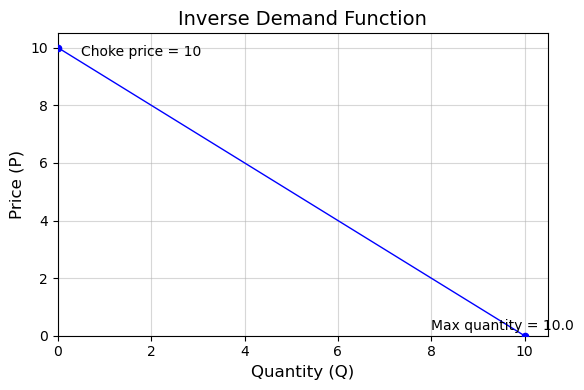

In [3]:
def plot_inverse_demand(end_points=False, ax=None, create_figure=True):
    Q = np.linspace(0, a/b, 100)  # From 0 to 10 (where price hits 0)
    P = a - b * Q  # Inverse demand function: P = a - b*Q

    # Handle axes and figure creation
    if ax is None and create_figure:
        fig, ax = plt.subplots(figsize=(6, 4))
    elif ax is None:
        ax = plt.gca()  # Get current axes
        fig = ax.figure
    else:
        fig = ax.figure

    # Create the plot
    ax.plot(Q, P, 'b-', linewidth=1)
    ax.set_xlabel('Quantity (Q)', fontsize=12)
    ax.set_ylabel('Price (P)', fontsize=12)
    ax.set_title('Inverse Demand Function', fontsize=14)
    ax.grid(True, alpha=0.5)

    # Mark key points
    if end_points:
        ax.scatter([0, a/b], [a, 0], color='blue', s=20, zorder=5)
        ax.text(0.5, a-0.3, f'Choke price = {a}', fontsize=10)
        ax.text(a/b-2, 0.2, f'Max quantity = {a/b}', fontsize=10)

    ax.set_xlim(0, a/b + 0.5)
    ax.set_ylim(0, a + 0.5)
    
    if create_figure:
        plt.tight_layout()
    
    return fig, ax

# Call the function to create and display the inverse demand curve
inverse_demand_fig, inverse_demand_ax = plot_inverse_demand(end_points=True)



#### Helper functions
The following functions are used to compute query market outcomes of the models, store results into a table and plot supply and demand curves.

In [ ]:
def market_price(m, round_value = True):
    x = [value(m.x[i]) for i in m.x]
    price = a - b*sum(x)
    if round_value:
        return round(price, 2)
    else:
        return price

def optimal_production(m):
    x = [round(value(m.x[i]),2) for i in m.x]
    return x

def market_share(m):
    x = [value(m.x[i]) for i in m.x]
    total_x = sum(x)
    if total_x == 0:
        shares = [0, 0, 0]
    else:
        shares = [round(xi / total_x, 2) for xi in x]
    return shares

def optimal_profits(m):
    profits = []
    p = market_price(m, round_value=False)
    for i in m.x:
        profit = p * value(m.x[i]) - m.c[i] * value(m.x[i])
        profit = max(0, profit) # All profitc are positive in these models, this avoids -0.0 values.
        profits.append(round(profit, 2))
    return profits

def social_welfare(m):
    welfare = a * sum(value(m.x[i]) for i in [1,2,3]) \
                    - b/2 * sum(value(m.x[i]) for i in [1,2,3])**2 \
                  - sum(m.c[i] * value(m.x[i]) for i in [1,2,3])
    return round(welfare,2)


def add_results_to_table(m, setup, table): 
    # Check if setup already exists in the table
    if len(table) == 0 or setup not in table[('Setup', '')].values:
        # Create new row data matching MultiIndex structure
        new_data = {
            ('Setup', ''): [setup],
            ('Market', 'Price'): [market_price(m)],
            ('Production', 'Firm1'): [optimal_production(m)[0]],
            ('Production', 'Firm2'): [optimal_production(m)[1]],
            ('Production', 'Firm3'): [optimal_production(m)[2]],
            ('Profit', 'Firm1'): [optimal_profits(m)[0]],
            ('Profit', 'Firm2'): [optimal_profits(m)[1]],
            ('Profit', 'Firm3'): [optimal_profits(m)[2]],
            ('Social', 'Welfare'): [social_welfare(m)]
        }
        
        new_row = pd.DataFrame(new_data)
        
        if len(table) == 0:
            # If table is empty, just return the new row
            table = new_row
        else:
            # Otherwise, concatenate normally
            table = pd.concat([table, new_row], ignore_index=True)
    return table

def show(table):
    #display(H ML(table.to_html(index=False)))
    # Convert to HTML with custom styling
    html = table.to_html(index=False, table_id="results")
    
    # Add CSS for left alignment
    styled_html = f"""
    <style>
    #results th, #results td {{
        text-align: left !important;
        padding: 6px 12px;
    }}
    #results th {{
        font-weight: bold;
    }}
    #results {{
        border-collapse: collapse;
    }}
    </style>
    {html}
    """
    
    display(HTML(styled_html))
   

In [9]:
def supply_demand_plot(c1, c2, c3, X1_max, X2_max, X3_max, title='', 
                       equilibrium_point=False, Q=0, P=0,
                       ax=None, create_figure=True, firm_labels=True, alpha=0.8):
    
    # Create or use existing figure/axes
    if ax is None and create_figure:
        fig, ax = plot_inverse_demand(end_points=False, create_figure=True)
    elif ax is None:
        fig, ax = plot_inverse_demand(end_points=False, create_figure=False)
    else:
        # Use provided axes, but still plot the inverse demand curve
        fig, ax = plot_inverse_demand(end_points=False, ax=ax, create_figure=False)
    
    # Create supply curves for each firm (marginal cost lines)
    # For perfectly competitive firms, supply curve is horizontal at marginal cost up to capacity
    firms = [
        {'name': 'Firm 1', 'cost': c1, 'capacity': X1_max},
        {'name': 'Firm 2', 'cost': c2, 'capacity': X2_max},
        {'name': 'Firm 3', 'cost': c3, 'capacity': X3_max}
    ]

    # Sort firms by marginal cost (lowest to highest)
    firms_sorted = sorted(firms, key=lambda x: x['cost'])

    # Create aggregate supply curve as step function
    supply_quantities = [0]  # Start at quantity 0
    supply_prices = [0]      # Start at price 0

    cumulative_quantity = 0
    for i, firm in enumerate(firms_sorted):
        # Add horizontal segment at firm's marginal cost
        supply_quantities.append(cumulative_quantity)
        supply_prices.append(firm['cost'])
        
        # Add capacity to cumulative quantity
        cumulative_quantity += firm['capacity']
        supply_quantities.append(cumulative_quantity)
        supply_prices.append(firm['cost'])

    # Add final segment to extend supply curve upward
    supply_quantities.append(cumulative_quantity)  # Final quantity
    supply_prices.append(20)  # Final price back to 0

    # Plot the aggregate supply curve
    ax.step(supply_quantities, supply_prices, where='post', color='darkred', 
            linewidth=2, alpha=alpha)

    # Plot individual firm contributions
    if firm_labels:
        cumulative_q = 0
        for i, firm in enumerate(firms_sorted):
            # Add capacity label
            ax.text(cumulative_q + firm['capacity']/2, firm['cost'] - 1, 
                    f"{firm['name']}\nCap = {firm['capacity']}", 
                    ha='center', fontsize=8, color='darkred')
            
            cumulative_q += firm['capacity']

    # Add equilibrium point
    if equilibrium_point:
        ax.scatter(Q, P, color='black', zorder=5)
        ax.text(Q + 0.05, P + 0.3, f'({Q}, {P})', fontsize=8)

    # Add grid and labels
    ax.set_title(title, fontsize=14, pad=20)

    # Set axis limits with some padding
    ax.set_xlim(0, max(a/b, X1_max + X2_max + X3_max) + 0.5)
    ax.set_ylim(0, a + 0.5)

    if create_figure:
        plt.tight_layout()

    return fig, ax

Initialising result dataframe that will be filled throughout the exercises.

In [5]:
columns = pd.MultiIndex.from_tuples([
    ('Setup', ''),
    ('Market', 'Price'),
    ('Production', 'Firm1'),
    ('Production', 'Firm2'),
    ('Production', 'Firm3'),
    ('Profit', 'Firm1'),
    ('Profit', 'Firm2'),
    ('Profit', 'Firm3'), 
    ('Social', 'Welfare')
])
results_table = pd.DataFrame(columns=columns)

show(results_table)

## Exercise #3.1 Perfect competition

### Task 1: Implementation of models

#### <span style="color:darkblue">Welfare-maximization model</span>

\begin{align*}
\text{Maximize}_{x_1, x_2, x_3} \quad
& \alpha \sum_{j=1}^{3} x_j
  - \frac{1}{2} \beta \left( \sum_{j=1}^{3} x_j \right)^2
  - \sum_{j=1}^{3} c_j x_j
\\
\text{s.t.} \quad
& x_i - X_i^{\max} \leq 0
    \qquad i = 1,2,3
\\
& -x_i \leq 0,
    \qquad i = 1,2,3.
\end{align*}

This is a standard quadratic program (QP), which can be solved with a standard **QP solver**. We will use an open-source solver called **SCIP**. It has an objective function, constraints and only primal variables.

In [6]:
def welfare_maximization_model(c1, c2, c3, X1_max, X2_max, X3_max):
  # Initialize model for welfare maximization (wm)
  wm = ConcreteModel()

  # Set of firms
  wm.I = Set(initialize=[1, 2, 3])
  
  # Define parameters
  wm.c = Param(wm.I, initialize={1:c1, 2:c2, 3:c3})
  wm.X_max = Param(wm.I, initialize={1:X1_max, 2:X2_max, 3:X3_max})

  # Define nonnegative variables
  wm.x = Var(wm.I, domain=NonNegativeReals)

  # Define objective function (social welfare maximization)
  wm.obj = Objective(expr = a * sum(wm.x[i] for i in wm.I) \
                      - b/2 * sum(wm.x[i] for i in wm.I)**2 \
                    - sum(wm.c[i] * wm.x[i] for i in wm.I), 
                    sense=maximize)

  # Define constraints (production capacities)
  def capacity_constraint_rule(m, i):
      return m.x[i] <= m.X_max[i]
  wm.capacity_constraint = Constraint(wm.I, rule=capacity_constraint_rule)

  # Solve the model with Gurobi
  solver = SolverFactory('scip', solver_io='nl')
  results = solver.solve(wm, tee=False) # tee=False suppresses solver output

  print("The solver found an", results.solver.termination_condition, "solution.")

  # Return model with results
  return wm

**Run model and query results**

In [7]:
welfare_model = welfare_maximization_model(c1, c2, c3, X1_max, X2_max, X3_max)
print("Market price:", market_price(welfare_model))
print("Optimal production (x):", optimal_production(welfare_model))
print("Optimal profits:", optimal_profits(welfare_model))
print("Social welfare:", social_welfare(welfare_model))

The solver found an optimal solution.
Market price: 4.0
Optimal production (x): [3.0, 3.0, 0.0]
Optimal profits: [3.0, 0, 0]
Social welfare: 21.0


The following sell adds the results to the results table.

In [8]:
results_table = add_results_to_table(welfare_model, 'Welfare Max', results_table)
show(results_table)

Visualise the supply and demand, identify welfare-maximizing equilibrium

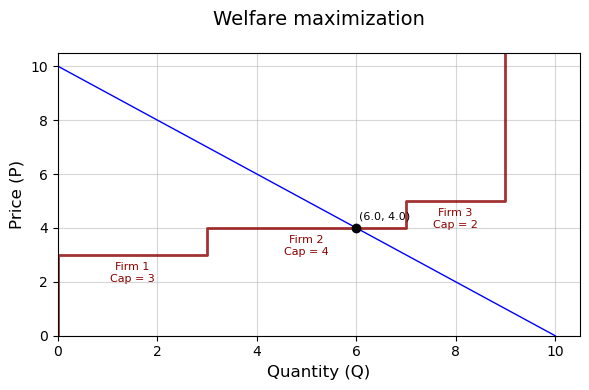

In [10]:
fig, _ = supply_demand_plot(c1, c2, c3, X1_max, X2_max, X3_max, title='Welfare maximization',
                            equilibrium_point=True, Q=sum(optimal_production(welfare_model)), P=market_price(welfare_model))

#### <span style="color:darkblue">Competitive-market model</span>
Note that this model models a perfect-competition Nash equilibrium.

\begin{align}
& 0 \leq x_i \perp c_i - \alpha + \beta \sum_j x_j + \mu_i^{\max} \geq 0, \quad \forall i \in \{1,2,3\}\\
& 0 \leq \mu_i^{\max} \perp X_i^{\max} - x_i  \geq 0, \quad \forall i \in \{1,2,3\}
\end{align}

This is a complementarity model, which does not have an objective function but is composed of **only complementarity conditions**. Solving it requires using the **PATH solver**, which employs a specific algorithm for this type of problem. In Python, we can use the Pyomo package, specifically it's pyomo.mpec extension for formulating the complementarity constraints.

In [45]:
def competitive_market_model(c1, c2, c3, X1_max, X2_max, X3_max):
    # Initialize competitive market model (m)
    m = ConcreteModel()

    # Set of firms
    m.I = Set(initialize=[1, 2, 3])

    # Define parameters
    m.c = Param(m.I, initialize={1:c1, 2:c2, 3:c3})
    m.X_max = Param(m.I, initialize={1:X1_max, 2:X2_max, 3:X3_max})

    # Define variables
    m.x = Var(m.I, domain=NonNegativeReals)
    m.mu = Var(m.I, domain=NonNegativeReals)  # Dual variables

    # Complementarity constraints
    # 0 ≤ x_i ⊥ (c_i - a + b*sum(x_j) + mu_i) ≥ 0
    def constraint_x_rule(m, i):
        return complements(0 <= m.x[i], m.c[i] - a + b * sum(m.x[j] for j in m.I) + m.mu[i] >= 0)
    m.constraint_x = Complementarity(m.I, rule=constraint_x_rule)

    # 0 ≤ mu_i ⊥ (X_max - x_i) ≥ 0  
    def constraint_mu_rule(m, i):
        return complements(0 <= m.mu[i], m.X_max[i] - m.x[i] >= 0)
    m.c_mu1 = Complementarity(m.I, rule=constraint_mu_rule)

    # Solve the model using PATH solver
    solver = SolverFactory('pathampl', executable=path_executable)
    results = solver.solve(m, tee=False) # tee=False suppresses solver output

    print("The solver found an", results.solver.termination_condition, "solution.")

    # Return model object with results
    return m

**Run model and query results**

In [48]:
competitive_model = competitive_market_model(c1, c2, c3, X1_max, X2_max, X3_max)
print("Market price:", market_price(competitive_model))
print("Optimal production (x):", optimal_production(competitive_model))
print("Optimal profits:", optimal_profits(competitive_model))
print("Social welfare:", social_welfare(competitive_model))

The solver found an optimal solution.
Market price: 4.0
Optimal production (x): [3.0, 3.0, 0.0]
Optimal profits: [3.0, 0.0, 0]
Social welfare: 21.0


In [13]:
# Add the results to the results table and display it
results_table = add_results_to_table(competitive_model, 'Competitive NE', results_table)
show(results_table)

Visualise the demand and supply curves to see the market equilibrium

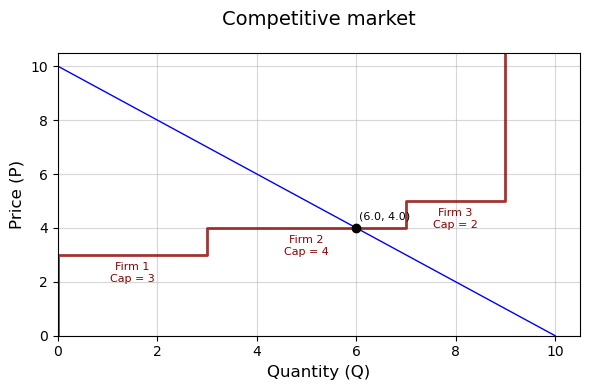

In [14]:
fig, _ = supply_demand_plot(c1, c2, c3, X1_max, X2_max, X3_max, title='Competitive market',
                            equilibrium_point=True, Q=sum(optimal_production(competitive_model)), P=market_price(competitive_model))

### Task 2: Sensitivity analysis

Change the costs of the firms so that firm 3 starts producing

In [15]:
# Change these values to see how the results change
c1_new = 3
c2_new = 4
c3_new = 5

cm_new = competitive_market_model(c1_new, c2_new, c3_new, X1_max, X2_max, X3_max)
print("Market price:", market_price(cm_new))
print("Optimal production (x):", optimal_production(cm_new))
print("Optimal profits:", optimal_profits(cm_new))
print("Social welfare:", social_welfare(cm_new))

## -- Uncomment the line below to plot the market-equilibrium with new costs
# plot = supply_demand_plot(c1_new, c2_new, c3_new, X1_max, X2_max, X3_max,
#                           equilibrium_point=True, Q=sum(optimal_production(cm_new)), P=market_price(cm_new))

The solver found an optimal solution.
Market price: 4.0
Optimal production (x): [3.0, 3.0, 0.0]
Optimal profits: [3.0, 0.0, 0]
Social welfare: 21.0


Increase the production capacities of the firms and observe the changes in the results.
 * Is there a change in the production allocation, if so why or why not?
 * How large would firm 1’s capacity have to be for it to set the market price? 


In [16]:
# Increase X_max values to see how the results change
X1_max_new = 3
X2_max_new = 4
X3_max_new = 2

cm_new = competitive_market_model(c1, c2, c3, X1_max_new, X2_max_new, X3_max_new)
print("Market price:", market_price(cm_new))
print("Optimal production (x):", optimal_production(cm_new))
print("Optimal profits:", optimal_profits(cm_new))
print("Social welfare:", social_welfare(cm_new))

## -- Uncomment the line below to plot the market-equilibrium with new capacities
# plot = supply_demand_plot(c1, c2, c3, X1_max_new, X2_max_new, X3_max_new,
#                           equilibrium_point=True, Q=sum(optimal_production(cm_new)), P=market_price(cm_new))

The solver found an optimal solution.
Market price: 4.0
Optimal production (x): [3.0, 3.0, 0.0]
Optimal profits: [3.0, 0.0, 0]
Social welfare: 21.0


## Exercise #3.2 Cournot competition

### Task 1: Implementation of model

#### <span style="color:darkblue">Cournot competition model</span>

\begin{align}
&0 \leq x_i \perp c_i + \beta x_i - \alpha + \beta \sum_{j} x_j + \mu_i^{\max} \geq 0, \quad i = 1, 2, 3\\
&0 \leq \mu_i^{\max} \perp X_i^{\max} - x_i  \geq 0, \quad i = 1, 2, 3
\end{align}


In [17]:
def cournot_market_model(c1, c2, c3, X1_max, X2_max, X3_max, print_status=True):
    # Initialize cournot market model (m)
    m = ConcreteModel()

    # Set of firms
    m.I = Set(initialize=[1, 2, 3])

    # Define parameters
    m.c = Param(m.I, initialize={1:c1, 2:c2, 3:c3})
    m.X_max = Param(m.I, initialize={1:X1_max, 2:X2_max, 3:X3_max})

    # Define variables
    m.x = Var(m.I, domain=NonNegativeReals)
    m.mu = Var(m.I, domain=NonNegativeReals)  # Dual variables

    # Complementarity constraints
    # 0 ≤ x_i ⊥ (c_i + bx_i - a + b*sum(x_j) + mu_i) ≥ 0
    def constraint_x_rule(m, i):
        return complements(0 <= m.x[i], m.c[i] + b * m.x[i] - a + b * sum(m.x[j] for j in m.I) + m.mu[i] >= 0)
    m.constraint_x = Complementarity(m.I, rule=constraint_x_rule)

    # 0 ≤ mu_i ⊥ (X_max - x_i) ≥ 0  
    def constraint_mu_rule(m, i):
        return complements(0 <= m.mu[i], m.X_max[i] - m.x[i] >= 0)
    m.c_mu1 = Complementarity(m.I, rule=constraint_mu_rule)

    # Solve the model using PATH solver
    solver = SolverFactory('pathampl', executable=path_executable)
    results = solver.solve(m, tee=False) # tee=False suppresses solver output

    if print_status:
        print("The solver found an", results.solver.termination_condition, "solution.")

    # Return model object with results
    return m

In [18]:
cournot_model = cournot_market_model(c1, c2, c3, X1_max, X2_max, X3_max)
print("Market price:", market_price(cournot_model))
print("Optimal production (x):", optimal_production(cournot_model))
print("Optimal profits:", optimal_profits(cournot_model))
print("Social welfare:", social_welfare(cournot_model))

The solver found an optimal solution.
Market price: 5.5
Optimal production (x): [2.5, 1.5, 0.5]
Optimal profits: [6.25, 2.25, 0.25]
Social welfare: 18.88


In [19]:
results_table = add_results_to_table(cournot_model, 'Cournot NE', results_table)
show(results_table)

Illustrate the Cournot market outcome versus the competitive market in a plot

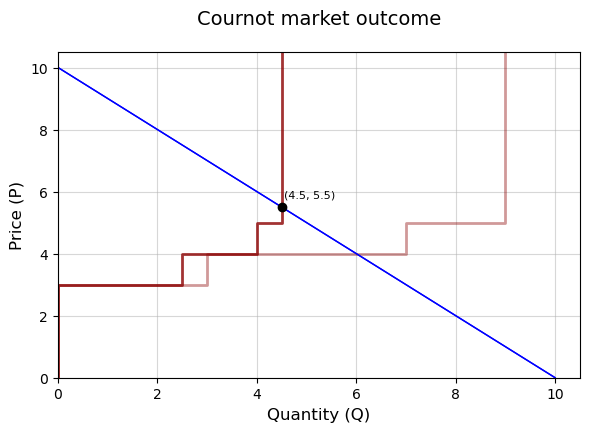

In [20]:
# Find optimal production quantities
q = optimal_production(cournot_model)

# Plot competitive supply curve
fig, ax = supply_demand_plot(c1, c2, c3, X1_max, X2_max, X3_max, firm_labels=False, alpha= 0.4)

# Plot Cournot supply curve
supply_demand_plot(c1, c2, c3, q[0], q[1], q[2], firm_labels=False, title = 'Cournot market outcome',
                   equilibrium_point=True, Q = sum(q), P=market_price(cournot_model),
                   ax= ax, create_figure=False);


### Task 2

Investigate the effect of increasing production capacities

In [ ]:
# Change X_max values so that a firm is able to fulfill maximum demand
X1_max_new = 3
X2_max_new = 4
X3_max_new = 2

# Run the Cournot model with new capacities
cournot_new = cournot_market_model(c1, c2, c3, X1_max_new, X2_max_new, X3_max_new)

# Print the results
print("Market price:", market_price(cournot_new))
print("Optimal production (x):", optimal_production(cournot_new))
print("Optimal profits:", optimal_profits(cournot_new))
print("Social welfare:", social_welfare(cournot_new))

# Uncomment the lines below to plot the Cournot market-equilibrium with new capacities
# q = optimal_production(cournot_new)
# supply_demand_plot(c1, c2, c3, q[0], q[1], q[2],
#                    equilibrium_point=True, Q = sum(q), P=market_price(cournot_new));

The solver found an optimal solution.
Market price: 4.67
Optimal production (x): [4.67, 0.67, 0.0]
Optimal profits: [21.78, 0.44, 0]
Social welfare: 36.44


Investigate the effect of changing firm 1's costs and plot how the **profit** and **market share** change

In [35]:
# Define cost values to test
c1_new = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


# With X = 10, a firm is able to fulfill maximum demand
X1_max_new = 10
X2_max_new = 10
X3_max_new = 10

# Initialize lists to store results
profits1 = []
market_shares1 = []
market_prices1 = []
quantities1 = []

# Iterate over different c1 values
for c in c1_new:
    # Solve model with c1 = c
    cournot_new = cournot_market_model(c, c2, c3, X1_max_new, X2_max_new, X3_max_new, print_status=False)

    # Save results
    profits1.append(optimal_profits(cournot_new)[0])
    market_shares1.append(market_share(cournot_new)[0])
    market_prices1.append(market_price(cournot_new))
    quantities1.append(optimal_production(cournot_new))

Plot the profits and market shares of firm 1 as well as the production allocation as a function of marginal cost c1.

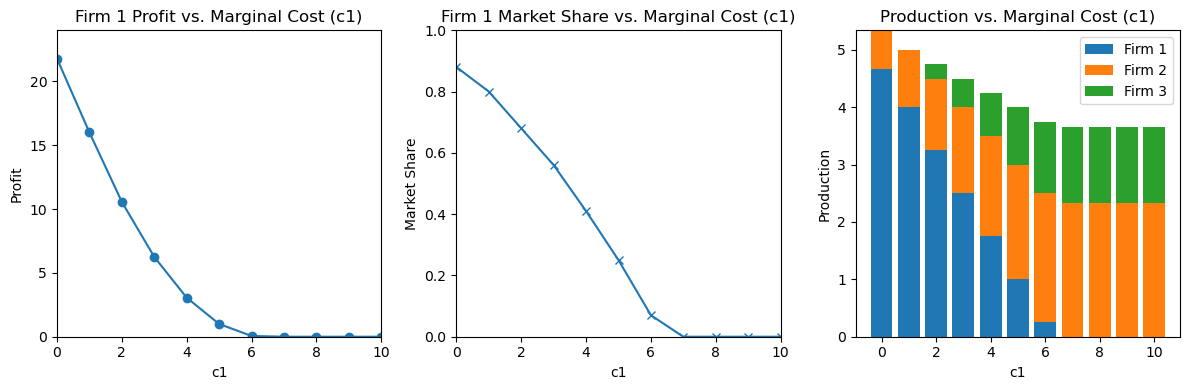

In [23]:
# Initialise subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

# Plot Firm 1 profit vs c1
ax1.plot(c1_new, profits1, marker='o')
ax1.set_title('Firm 1 Profit vs. Marginal Cost (c1)')

# Plot Firm 1 market share vs c1
ax2.plot(c1_new, market_shares1, marker='x')
ax2.set_title('Firm 1 Market Share vs. Marginal Cost (c1)')

# Plot production allocation vs c1
quantities1 = np.array(quantities1)
ax3.bar(c1_new, quantities1[:, 0], label='Firm 1')
ax3.bar(c1_new, quantities1[:, 1], bottom=quantities1[:, 0], label='Firm 2')
ax3.bar(c1_new, quantities1[:, 2], bottom=quantities1[:, 0]+quantities1[:, 1], label='Firm 3')
ax3.set_title('Production vs. Marginal Cost (c1)')

# Additional plot settings
ax1.set_xlabel('c1')
ax1.set_ylabel('Profit')
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 24)
ax2.set_xlabel('c1')
ax2.set_ylabel('Market Share')
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1)
ax3.set_xlabel('c1')
ax3.set_ylabel('Production')
ax3.legend()
plt.tight_layout()

# Show plot
plt.show()

## Exercise #3.3 Generalized Nash equilibrium

### Task 1: Implementation
#### <span style="color:darkblue">Generalized Nash equilibrium model</span>

\begin{align}
&0 \leq x_i \perp c_i + \beta x_i - \alpha + \beta \sum_j x_j + \mu_i^{\max} + \delta_i \geq 0, \quad i = 1,2,3\\
&0 \leq \mu_i^{\max} \perp X_i^{\max} - x_i \geq 0, \quad i = 1,2,3 \\
&0 \leq \delta_i \perp X^{\text{total}} - \sum_i x_i  \geq 0
\end{align}

Notice that the dual variables $\delta_i$, must have equal values in the solution. In the implementation, we can ensure this either by defining a constraint $$\delta_1 = \delta_2 = \delta_3,$$ or by simply modelling the variables with a single variable $\delta$ and using this variable in all of the players' problems. In this implementation, we use a single variable $\delta$.

In [38]:
def GNE_market_model(c1, c2, c3, X1_max, X2_max, X3_max, X_total, print_status=False):
    # Initialize cournot market model (m)
    m = ConcreteModel()

    # Set of firms
    m.I = Set(initialize=[1, 2, 3])

    # Define parameters
    m.c = Param(m.I, initialize={1:c1, 2:c2, 3:c3})
    m.X_max = Param(m.I, initialize={1:X1_max, 2:X2_max, 3:X3_max})

    # Define variables
    m.x = Var(m.I, domain=NonNegativeReals)
    m.mu = Var(m.I, domain=NonNegativeReals)  # Dual variables
    m.delta = Var(domain=NonNegativeReals)  # New dual variable for GNE - one shared among firms

    # Complementarity constraints
    # 0 ≤ x_i ⊥ (c_i + bx_i - a + b*sum(x_j) + mu_i + delta) ≥ 0
    def constraint_x_rule(m, i):
        return complements(0 <= m.x[i], m.c[i] + b * m.x[i] - a + b * sum(m.x[j] for j in m.I) + m.mu[i] + m.delta >= 0)
    m.constraint_x = Complementarity(m.I, rule=constraint_x_rule)

    # 0 ≤ mu_i ⊥ (X_max - x_i) ≥ 0  
    def constraint_mu_rule(m, i):
        return complements(0 <= m.mu[i], m.X_max[i] - m.x[i] >= 0)
    m.c_mu1 = Complementarity(m.I, rule=constraint_mu_rule)

    # GNE-specific constraint
    # 0 ≤ delta_i ⊥ X^total - sum(x_j) ≥ 0
    m.c_delta = Complementarity(expr = 
                                complements(0 <= m.delta, X_total - sum(m.x[j] for j in m.I) >= 0))


    # Solve the model using PATH solver
    solver = SolverFactory('pathampl', executable=path_executable)
    results = solver.solve(m, tee=False) # tee=False suppresses solver output

    if print_status:
        print("The solver found an", results.solver.termination_condition, "solution.")

    # Return model object with results
    return m

In [39]:
X_total = 4

GNE_model = GNE_market_model(c1, c2, c3, X1_max, X2_max, X3_max, X_total, print_status=True)
print("Market price:", market_price(GNE_model))
print("Optimal production (x):", optimal_production(GNE_model))
print("Optimal profits:", optimal_profits(GNE_model))
print("Social welfare:", social_welfare(GNE_model))

The solver found an optimal solution.
Market price: 6.0
Optimal production (x): [2.33, 1.33, 0.33]
Optimal profits: [7.0, 2.67, 0.33]
Social welfare: 18.0


In [40]:
results_table = add_results_to_table(GNE_model, 'GNE', results_table)
show(results_table)

### Task 2: Vary cap on total supply

In [41]:
X_total_new = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

delta_values_GNE = []
market_prices_GNE = []
quantities_GNE = []

for X in X_total_new:
    GNE_model_new = GNE_market_model(c1, c2, c3, X1_max, X2_max, X3_max, X)
    delta_values_GNE.append(round(value(GNE_model_new.delta), 2))
    market_prices_GNE.append(market_price(GNE_model_new))
    quantities_GNE.append(optimal_production(GNE_model_new))

In [ ]:
# Initialise subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

# Plot Firm 1 profit vs supply cap
ax1.plot(X_total_new, delta_values_GNE, marker='o')
ax1.set_title('Supply cap vs. Lagrange multiplier')

# Plot Firm 1 market share vs supply cap
ax2.plot(X_total_new, market_prices_GNE, marker='x')
ax2.set_title('Supply cap vs. market prices')

# Plot production allocation vs supply cap
quantities_GNE = np.array(quantities_GNE)
ax3.bar(X_total_new, quantities_GNE[:, 0], label='Firm 1')
ax3.bar(X_total_new, quantities_GNE[:, 1], bottom=quantities_GNE[:, 0], label='Firm 2')
ax3.bar(X_total_new, quantities_GNE[:, 2], bottom=quantities_GNE[:, 0]+quantities_GNE[:, 1], label='Firm 3')
ax3.set_title('Supply cap vs. Production Allocation ')

# Additional plot settings
ax1.set_xlabel('X^total')
ax1.set_ylabel('Lagrange multiplier')
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 8)
ax2.set_xlabel('X^total')
ax2.set_ylabel('Market price')
ax2.set_xlim(0, 10)
ax2.grid(True, alpha = 0.5)
ax1.grid(True, alpha = 0.5)
ax2.set_ylim(0, 10)
ax3.set_xlabel('X^total')
ax3.set_ylabel('Production allocation')
ax3.legend()
plt.tight_layout()

# Show plot
plt.show()

## Exercise #3.4 Stackelberg game

Here we assume a Stackelberg game where firm 1 is the leader and firms 2 and 3 are followers. The leader anticipates the reaction of the followers to its production decision. The lower-level problem is a Cournot market. The leader's problem can be formulated as a bilevel optimization problem:


\begin{align}
    \min_{x_1, x_2, x_3} \quad & c_1 x_1 - \left( \alpha - \beta \sum_{i=1}^{3} x_i \right) x_1 \\
    \text{s.t.} \quad & x_1 - X_1^{\max} \leq 0 \\
    & -x_1 \leq 0 \\
    & \text{Lower-level problem:} \nonumber \\
    &0 \leq x_i \perp c_i + \beta x_i - \alpha + \beta \sum_j x_j + \mu_i^{\max} \geq 0, \quad i = 2,3\\
    &0 \leq \mu_i^{\max} \perp X_i^{\max} - x_i \geq 0, \quad i = 2,3 \\
\end{align}

This model has several complexities: a  <span style="color:orange">**quadratic objective**</span> and <span style="color:orange">**complementarity constraints**</span>. The objective is <span style="color:orange">**convex**</span>. This type of problem cannot be implemented directly but requires reformulation.



### Task 1: Implementation of model with SOS1 variable reformulation

#### SOS1 variable transformation



In the special ordered sets 1 (SOS1) variable transformation, a complementarity constraint of the form $$0 \leq x \perp F(x) \geq 0$$ is reformulated and results in the following constraints:

\begin{align*}
    &2 (v^+ + v^-) = x + F(x) \\
    & 2 (v^+ - v^-) = x - F(x) \\
    & F(x) \geq 0 \\
    & v^+, v^- \text{ are SOS1} \\
    & v^+, v^-, x \geq 0 \\
\end{align*}

 To solve this, we need a solver that can handle <span style="color:orange">**quadratic programs (QP) with SOS1 variables**</span>. We will use the open-source solver **SCIP**.

The following function implements the SOS1 variable transformation into model `m` for a variable `var`and a function `fun` representing $F(var)$. 

In [42]:
def sos1_variable_transformation(m:ConcreteModel, var:Var, fun:Expression):
    # Adding SOS1 variables to model
    m.add_component('v_plus_' + var.name,Var(domain=NonNegativeReals))
    m.add_component('v_minus_' + var.name, Var(domain=NonNegativeReals))

    # Creating python variables pointin to model variables for easy access
    v_plus = m.component('v_plus_' + var.name)
    v_minus = m.component('v_minus_' + var.name)
    
    # Add constraints to the model
    m.add_component('SOS1_' + var.name + '_nonnegativity', 
                   Constraint(expr = fun >= 0))
    
    m.add_component('SOS1_' + var.name + '_addition', 
                   Constraint(expr = 2*(v_plus + v_minus) == var + fun))
    
    m.add_component('SOS1_' + var.name + '_subtraction', 
                   Constraint(expr = 2*(v_plus - v_minus) == var - fun))
    
    # Create function for generating SOS1 constraints
    def SOS1_rule(m):
        vars_list = [v_plus, v_minus]
        weights = [1, 2] # mandatory to specify weights, these may affect computation performance but for now set naively. 
        return vars_list, weights
    
    m.add_component('SOS1_' + var.name + '_constraint',
                    SOSConstraint(rule=SOS1_rule, sos=1))

For ease of reading the code, the leader's problem is repeated here:

\begin{align}
    \min_{x_1, x_2, x_3} \quad & c_1 x_1 - \left( \alpha - \beta \sum_{i=1}^{3} x_i \right) x_1 \\
    \text{s.t.} \quad & x_1 - X_1^{\max} \leq 0 \\
    & -x_1 \leq 0 \\
    & \text{Lower-level problem:} \nonumber \\
    &0 \leq x_i \perp c_i + \beta x_i - \alpha + \beta \sum_j x_j + \mu_i^{\max} \geq 0, \quad i = 2,3\\
    &0 \leq \mu_i^{\max} \perp X_i^{\max} - x_i \geq 0, \quad i = 2,3 \\
\end{align}

In [43]:
def MPEC_firm1_leader_model(c1, c2, c3, X1_max, X2_max, X3_max):
    # Initialize MPEC market model (m)
    m = ConcreteModel()

    # Set of firms
    m.I = Set(initialize=[1, 2, 3])

    # Define parameters
    m.c = Param(m.I, initialize={1:c1, 2:c2, 3:c3})
    m.X_max = Param(m.I, initialize={1:X1_max, 2:X2_max, 3:X3_max})

    # Define variables
    m.x = Var(m.I, domain=NonNegativeReals)
    m.mu = Var(m.I, domain=NonNegativeReals)  # Dual variables

    # Define objective function for firm 1 (leader)
    def negative_profit_firm1(m):
        price = a - b * sum(m.x[j] for j in m.I)
        return m.c[1] * m.x[1] - price * m.x[1]
    m.profit1 = Objective(rule=negative_profit_firm1, sense=minimize)

    # Primal constraint for leader firm 1
    m.capacity_constraint1 = Constraint(expr = m.x[1] <= m.X_max[1])

    # Complementarity constraints for firm 2 and firm 3 (followers)
    # 0 ≤ x_i ⊥ c_i + bx_i - a + b*sum(x_j) + mu_i ≥ 0 for i = 2, 3
    def function_x(m, i):
        return m.c[i] + b * m.x[i] - a + b * sum(m.x[j] for j in m.I) + m.mu[i]
    #m.fun_x2 = Expression(rule= function_x(m, 2))

    sos1_variable_transformation(m, m.x[2], function_x(m, 2))
    sos1_variable_transformation(m, m.x[3], function_x(m, 3))
    
    
    # 0 ≤ mu_i ⊥ (X_max - x_i) ≥ 0 for i = 2, 3
    def function_mu(m, i):
        return m.X_max[i] - m.x[i]
    sos1_variable_transformation(m, m.mu[2], function_mu(m, 2))
    sos1_variable_transformation(m, m.mu[3], function_mu(m, 3))

    # Solve the model using SCIP solver
    solver = SolverFactory('scip', solver_io='nl')
    results = solver.solve(m, tee=False) # tee=False suppresses solver output

    print("The solver found an", results.solver.termination_condition, "solution.")

    return m

In [ ]:
mpec_model = MPEC_firm1_leader_model(c1, c2, c3, X1_max, X2_max, X3_max)
print("Market price:", market_price(mpec_model))
print("Optimal production (x):", optimal_production(mpec_model))
print("Optimal profits:", optimal_profits(mpec_model))
print("Social welfare:", social_welfare(mpec_model))

In [ ]:
results_table = add_results_to_table(mpec_model, 'MPEC', results_table)
show(results_table)

### Task 2: Sensitivity analysis on costs of leader

In [ ]:
#TODO: ADD sensitivity analysis on c1

#### EXTRA Task: Big-M reformulation

In the big-M variable transformation, a complementarity constraint of the form $$0 \leq x \perp F(x) \geq 0$$ is reformulated and results in the following constraints:

\begin{align*}
    & x \leq Mz \\
    & F(x) \leq M(1-z) \\
    & F(x) \geq 0 \\
    & x \geq 0 \\
    & z \in \{0, 1\}
\end{align*}



For firm 1's bilevel problem this would mean:

\begin{align}
    \min_{x_1, x_2, x_3} \quad & c_1 x_1 - \left( \alpha - \beta \sum_{i=1}^{3} x_i \right) x_1 \\
    \text{s.t.} \quad & x_1 - X_1^{\max} \leq 0 \\
    & -x_1 \leq 0 \\
    & \text{Lower-level problem:} \nonumber \\
    & \text{Nonnegativity:} \nonumber \\
    & 0 \leq x_i, \quad & i = 2, 3\\
    & 0 \leq c_i + \beta x_i - \alpha + \beta \sum_j x_j + \mu_i^{\max}, \quad & i = 2, 3\\
    & 0 \leq \mu_i^{\max}, \quad & i = 2, 3\\
    & 0 \leq X_i^{\max} - x_i, \quad & i = 2, 3\\
    & \text{Complementarity:} \nonumber \\
    & x_i \leq M z_i, \quad & i = 2, 3 \\
    & c_i + \beta x_i - \alpha + \beta \sum_j x_j + \mu_i^{\max} \leq M (1 - z_i), \quad & i = 2,3\\
    & \mu_i^{\max} \leq M y_i, \quad & i = 2, 3 \\
    & X_i^{\max} - x_i \leq M (1 - y_i), \quad & i = 2,3 \\
    & \text{Auxiliary variable definitions:} \nonumber \\
    & z_i, y_i \in \{0, 1\}, \quad & i = 2, 3
\end{align}

To solve this, we need a solver that can handle <span style="color:orange">**mixed-integer quadratic programs (MIQP)**</span> and we need to *choose* the big-M values. You can use **SCIP** for this as well.

In [ ]:
# Implement the big-M formulation here

# Define model


# Define variables


# Define objective function


# Define top-level constraints


# Define lower-level KKT conditions


# Solve the model